In [1]:
import numpy as np
import numpy.random as rd
import matplotlib as mpl
import matplotlib.pyplot as plt
import networkx as nx
import torch as tc
import tensorflow as tf
import argparse
import pickle
import pandas as pd
from circuit_solver import circuit as ct
from circuit_solver import elements as es
from circuit_solver import utils
from circuit_solver.learning import CoupledLearning, CLTrainingConfig, CLTestingConfig

In [9]:
# data params
downsample_size = (5,5)
input_gain = 10.0
output_gain = 1.0

# Define parameter ranges
k_min = 1E-1       
k_max = 1E1

# Two ways of setting parameter ranges
param_ranges = [(k_min, k_max)]
element_1 = es.Resistor(param_ranges=param_ranges)
element_2 = es.Resistor()
element_2.param_ranges = [(k_min, k_max)]

# Architecture params
N = downsample_size[0] * downsample_size[1] 
reverse_positives = False
reverse_negatives = False       # make the diodes between diodes and outputs point away from outputs

# training_config
batch_size = 50
eta = 0.5
alpha = 0.01
N_epochs = 1

training_config = CLTrainingConfig(
    batch_size=batch_size,
    N_epochs=N_epochs,
    eta=eta,
    alpha=alpha
)

absolute_high = max(input_gain, output_gain) 
model_config = ct.CircuitModelConfig(
    HIGH_voltage=absolute_high,
    LOW_voltage=-absolute_high,
)

### Load and process data

In [10]:
# Training examples from the dataset. Initial shapes: x_train (P, 28, 28), y_train (P,)
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# Turn data into format that can be passed into circuit model
X_train, Y_train = utils.preprocess_MNIST_data(x_train, y_train, size=downsample_size, X_gain=input_gain, Y_gain=output_gain)
X_test, Y_test = utils.preprocess_MNIST_data(x_test, y_test, size=downsample_size, X_gain=input_gain, Y_gain=output_gain)

P_train, _ = X_train.shape
P_test, M = Y_test.shape

### Build circuit models

In [11]:
segment_sizes = (0, 0, 0, N, N, M)
N_nodes = sum(segment_sizes)
graph = nx.Graph()
graph.add_nodes_from(np.arange(N_nodes))

# define indices for different node types
GROUND, HIGH, LOW, xp_inds, xn_inds, y_inds = utils.segment_array(graph.nodes, segment_sizes)   # HIGH = [], LOW = []

x_inds = xp_inds + xn_inds
fixed_inds = GROUND + HIGH + LOW

# bipartite graph
xp_edges = utils.all_pairs_between(xp_inds, y_inds)
xn_edges = utils.all_pairs_between(xn_inds, y_inds)
fixed_edges = utils.all_pairs_between(fixed_inds, y_inds)
all_edges = xp_edges + xn_edges + fixed_edges
graph.add_edges_from(all_edges)

# check that graph is connected
if not nx.is_connected(graph):
    print('graph is not connected!')

element_dict_1 = {
    element_1 : xp_edges + xn_edges,
}

element_dict_2 = {
    element_1 : xn_edges,
    element_2 : xp_edges
}

circuit_1 = ct.Circuit(graph, element_dict_1)
circuit_2 = ct.Circuit(graph, element_dict_2)
# plt.subplots(dpi=300)
# plt.imshow(circuit_1.Del.toarray().T, cmap='bwr')

/Users/adamkline/Documents/Projects/circuit-solver/circuit_solver/circuit.py:127: UserWarning: 
Duplicate element names found. Renamed elements:
  Resistor -> Resistor_1

  warnings.warn(warning_msg, UserWarning)


In [12]:
node_type_dict = {
    'GROUND': GROUND,
    'HIGH': HIGH,
    'LOW': LOW,
    'x': x_inds,
    'y': y_inds,
}

model_config = ct.CircuitModelConfig(
    HIGH_voltage=absolute_high,
    LOW_voltage=-absolute_high,
    optimizer='adam'
)
model_1 = ct.CircuitModel(circuit_1, node_type_dict, model_config)
model_2 = ct.CircuitModel(circuit_2, node_type_dict, model_config)

In [13]:
x = tc.tensor(X_train[0][None])
y = tc.tensor(Y_train[0][None])

model_1.set_inputs(x_inds)
model_2.set_inputs(x_inds)

In [14]:
V_node_1, hist_1 = model_1(x)
V_node_2, hist_2 = model_2(x)

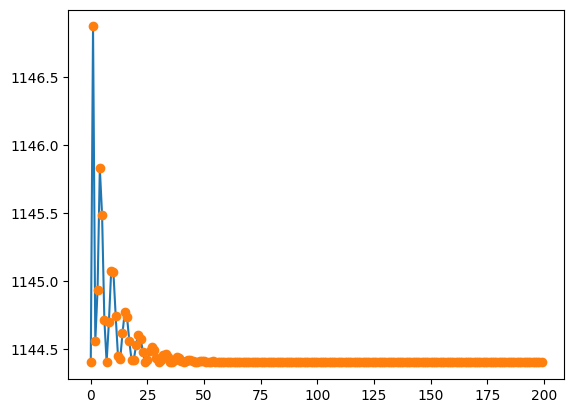

In [15]:
plt.plot(hist_1)
plt.plot(hist_2, 'o')